## Loading Dataset

In [110]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
from  scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline
conn = psycopg2.connect("dbname=musicdatabase")
cur = conn.cursor()

## Creating DataFrames

In [111]:
#GENRES:
cur.execute("SELECT * FROM genres")
names = [description[0] for description in cur.description]
genres = cur.fetchall()
genres_df = pd.DataFrame(genres, columns=names)

# #ARTISTS
cur.execute("SELECT * FROM artists")
names = [description[0] for description in cur.description]
artists = cur.fetchall()
artists_df = pd.DataFrame(artists, columns=names)

# #CONTENT
cur.execute("SELECT * FROM content")
names = [description[0] for description in cur.description]
content = cur.fetchall()
content_df = pd.DataFrame(content, columns=names)

# #LABELS
cur.execute("SELECT * FROM labels")
names = [description[0] for description in cur.description]
labels = cur.fetchall()
labels_df = pd.DataFrame(labels, columns=names)

# #REVIEWS
cur.execute("SELECT * FROM reviews")
names = [description[0] for description in cur.description]
reviews = cur.fetchall()
reviews_df = pd.DataFrame(reviews, columns=names)

# #YEARS
cur.execute("SELECT * FROM years")
names = [description[0] for description in cur.description]
years = cur.fetchall()
years_df = pd.DataFrame(years, columns=names)

## Exploring the Data

In [112]:
print('genre df length: ', len(genres_df))
print('artists df length: ', len(artists_df))
print('content df length: ', len(content_df))
print('labels df length: ', len(labels_df))
print('reviews df length: ', len(reviews_df))
print('years df length: ', len(years_df))

genre df length:  22680
artists df length:  18831
content df length:  18393
labels df length:  20190
reviews df length:  18393
years df length:  19108


In [113]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18393 entries, 0 to 18392
Data columns (total 13 columns):
reviewid          18393 non-null int64
title             18393 non-null object
artist            18393 non-null object
url               18393 non-null object
score             18393 non-null float64
best_new_music    18393 non-null int64
author            18393 non-null object
author_type       14487 non-null object
pub_date          18393 non-null object
pub_weekday       18393 non-null int64
pub_day           18393 non-null int64
pub_month         18393 non-null int64
pub_year          18393 non-null int64
dtypes: float64(1), int64(6), object(6)
memory usage: 1.8+ MB


In [114]:
reviews_df.isna().sum()
#no NANs in column 1.. however 2367 in column 2

reviewid             0
title                0
artist               0
url                  0
score                0
best_new_music       0
author               0
author_type       3906
pub_date             0
pub_weekday          0
pub_day              0
pub_month            0
pub_year             0
dtype: int64

## Scratch Work & More Review

In [115]:
reviews_df['author'].value_counts()
reviews_df['author'].nunique()

432

In [116]:
reviews_df['artist'].value_counts().head()

various artists     688
guided by voices     23
david bowie          21
the beatles          21
mogwai               20
Name: artist, dtype: int64

In [117]:
len(set(reviews_df['reviewid']))
#reviews_df['reviewid'].nunique()  #does the same thing

18389

## Seeing Which Tables Have Multiple Rows Per Song

In [118]:
genres_df.loc[genres_df['reviewid'] == 11733]
#example, song 6523 has 4 artists

,reviewid,genre
15417,11733,rock
15418,11733,global
15419,11733,experimental
15420,11733,electronic


* Review Table -- has 4 songs that have 2 reviewid's... i believe this is an error as all rows are identical
* Content Table -- also has 4 songs with 2 reviewid's... will remove the duplicated rows
* Genres Tabel -- Many songs have 2+ genres
* Labels Tabel -- Many songs have 2+ labels
* Artists Tabel -- Many songs have 2+ artists
* Year Tabel -- Many songs have 2+ release years... this may be an error... considering keeping only oldest year

In [119]:
genres_df['reviewid'].value_counts().head(10)

11733    4
21701    4
7683     4
757      4
12222    4
14812    4
12625    4
22465    4
9530     4
9036     4
Name: reviewid, dtype: int64

## Combining Genre and Review Tables

First, one hot encode genres table. 

In [120]:
# genres_df['pop/r&b'] = genres_df['genre'].apply(lambda x: 1 if x == 'pop/r&b' else 0)
# genres_df['electronic'] = genres_df['genre'].apply(lambda x: 1 if x == 'electronic' else 0)

In [121]:
genres_one_hot = pd.get_dummies(genres_df['genre'])
genres_one_hot.head()
genres_hot_df = pd.concat([genres_df, genres_one_hot], axis = 1)
genres_hot_df.head()

,reviewid,genre,electronic,experimental,folk/country,global,jazz,metal,pop/r&b,rap,rock
0,22703,electronic,1,0,0,0,0,0,0,0,0
1,22721,metal,0,0,0,0,0,1,0,0,0
2,22659,rock,0,0,0,0,0,0,0,0,1
3,22661,rock,0,0,0,0,0,0,0,0,1
4,22725,electronic,1,0,0,0,0,0,0,0,0


Second, filtered genres table for only pop & electric

In [122]:
genres_hot_df_filtered = genres_hot_df[(genres_hot_df['pop/r&b'] == 1) | (genres_hot_df['electronic'] == 1)]
genres_hot_df_filtered = genres_hot_df_filtered[['reviewid', 'electronic', 'pop/r&b']]
genres_hot_df_filtered.head()

,reviewid,electronic,pop/r&b
0,22703,1,0
4,22725,1,0
7,22694,1,0
12,22700,1,0
18,22719,0,1


Third, add value_count column in order to remove any albums that fall under both electronic & pop.

In [123]:
z = genres_hot_df_filtered['reviewid'].value_counts()
z1 = z.to_dict()
genres_hot_df_filtered['value_count'] = genres_hot_df_filtered['reviewid'].apply(lambda x: z1[x])
genres_hot_df_filtered.head()

,reviewid,electronic,pop/r&b,value_count
0,22703,1,0,1
4,22725,1,0,1
7,22694,1,0,1
12,22700,1,0,1
18,22719,0,1,1


Remove albums with both electronic and pop (where value_counts = 2)

In [124]:
to_drop = genres_hot_df_filtered[genres_hot_df_filtered['value_count'] == 2]
genres_df = genres_hot_df_filtered.drop(to_drop.index, axis=0)
genres_df.head()

,reviewid,electronic,pop/r&b,value_count
0,22703,1,0,1
4,22725,1,0,1
7,22694,1,0,1
12,22700,1,0,1
18,22719,0,1,1


Merge the new Genre Table with the existing Review Table

In [125]:
#rg = review & genres
rg_df = reviews_df.merge(genres_df, left_on='reviewid', right_on='reviewid')
rg_df.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,electronic,pop/r&b,value_count
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,1,0,1
1,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017,1,0,1
2,22694,tehillim,yotam avni,http://pitchfork.com/reviews/albums/22694-tehi...,7.0,0,andy beta,contributor,2017-01-05,3,5,1,2017,1,0,1
3,22700,nadir,steven warwick,http://pitchfork.com/reviews/albums/22700-nadir/,7.6,0,thea ballard,contributor,2017-01-03,1,3,1,2017,1,0,1
4,22719,merry christmas lil mama,"chance the rapper, jeremih",http://pitchfork.com/reviews/albums/22719-merr...,8.1,0,sheldon pearce,associate staff writer,2016-12-30,4,30,12,2016,0,1,1


## Hypothesis Test #1 
* Null: There is no statistically significant difference between the reviews for pop/R&B albums and electronic music albums.
* Alternative: The reviews for pop/R&B albums and electronic albums have a statistically significant difference between how they are reviewed, either positively or negatively. 

In [126]:
pop_df = rg_df[rg_df['pop/r&b'] == 1].copy()
elec_df = rg_df[rg_df['electronic'] == 1].copy()

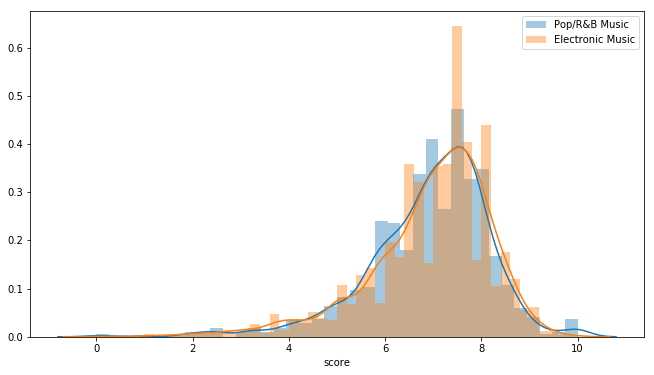

In [127]:
plt.figure(figsize=(11,6))
sns.distplot(pop_df['score'], label="Pop/R&B Music")
sns.distplot(elec_df['score'], label="Electronic Music");
plt.legend();

In [128]:
pop_df['score'].mean() - elec_df['score'].mean()

-0.01573202690610831

In [129]:
t_stat, p_val = ttest_ind(pop_df['score'],elec_df['score'])
print(f"T-Statistic: {t_stat}\nP-Value: {p_val}")

T-Statistic: -0.36421091026425517
P-Value: 0.7157164040794012


#### Finding Appropriate Sample Size

In [130]:
def sample_size_calc(var1, var2, moe=.5):
    std_var1 = var1.std()
    std_var2 = var2.std()
    count_var1 = len(var1)
    count_var2 = len(var2)

    std_p = (( (count_var1-1) * (std_var1**2) ) + ( (count_var2-1) * (std_var2**2) )) / (count_var1 + count_var2 - 2)
    return 2*( ((1.96 * std_p)/moe)**2 )

In [131]:
sample_size_calc(pop_df['score'],elec_df['score'])

87.64595381733723

Appropriate sample size must be greater than 87.6

In [132]:
samp_size = 90

#### Bootstrap Check

In [133]:
bootstrap_pop_sample = []
bootstrap_elec_sample = []

bootstrap_pop_sample_means = np.zeros(100)
bootstrap_elec_sample_means = np.zeros(100)

# boostrap_sample_means = np.zeros(1000)
# boostrap_sample_95pcts = np.zeros(1000)

for i in range(100):
    bootstrap_pop_samp = np.random.choice(pop_df['score'], size=samp_size, replace=True)
    bootstrap_elec_samp = np.random.choice(elec_df['score'], size=samp_size, replace=True)
    
    bootstrap_pop_sample.append(bootstrap_pop_samp)
    bootstrap_elec_sample.append(bootstrap_elec_samp)
    
    bootstrap_pop_sample_means[i] = bootstrap_pop_samp.mean()
    bootstrap_elec_sample_means[i] = bootstrap_elec_samp.mean()
#     bootstrap_sample_95pct = np.percent(a=boostrap_sample, q=95)
#     boostrap_sample_95pcts[i] = boostrap_sample_95pcts

print('Pop Sample Means Stdv: ', bootstrap_pop_sample_means.std())
print('Electric Sample Means Stdv: ', bootstrap_elec_sample_means.std())

print('Pop 2.5 Percentile: ', np.percentile(a=bootstrap_pop_sample_means, q=2.5))
print('Pop 97.5 Percentile: ', np.percentile(a=bootstrap_pop_sample_means, q=97.5))

print('Electronic 2.5 Percentile: ', np.percentile(a=bootstrap_elec_sample_means, q=2.5))
print('Electronic 97.5 Percentile: ', np.percentile(a=bootstrap_elec_sample_means, q=97.5))

# pop.mean()

Pop Sample Means Stdv:  0.12235965202812742
Electric Sample Means Stdv:  0.14381891005319464
Pop 2.5 Percentile:  6.674527777777778
Pop 97.5 Percentile:  7.162444444444443
Electronic 2.5 Percentile:  6.65936111111111
Electronic 97.5 Percentile:  7.185833333333333


#### Summary

Through our exploration, we found there to be very little variability between the rating of the two genres. We found a p-value of .716, which far exceeds our threshold of .05, telling us that we must accept our null hypothesis that there is not a statistically significant difference between the rating of pop/R&B and electronic albums.

In our further bootstrap test, sampling our data, we did not find significant variability in the performance of our two groups.

## Hypothesis Test #2
* Null: There is no statistically significant difference between sel-released albums and ratings from all others.
* Alternative: Self-released albums peform worse than those produced by record companies.

In [134]:
multi_label = dict(labels_df['reviewid'].value_counts())
labels_df['label count'] = labels_df['reviewid'].apply(lambda x: multi_label[x])
labels_df.head()

,reviewid,label,label count
0,22703,virgin,1
1,22721,hathenter,1
2,22659,static shock,2
3,22659,fashionable idiots,2
4,22661,kill rock stars,2


In [135]:
to_drop = labels_df[labels_df['label count'] > 1]
label_solo_df = labels_df.drop(to_drop.index, axis=0)

In [136]:
revlab_df = reviews_df.merge(label_solo_df, left_on='reviewid', right_on='reviewid')

In [137]:
self_df = revlab_df[revlab_df['label'] == 'self-released']
label_df = revlab_df[revlab_df['label'] != 'self-released']

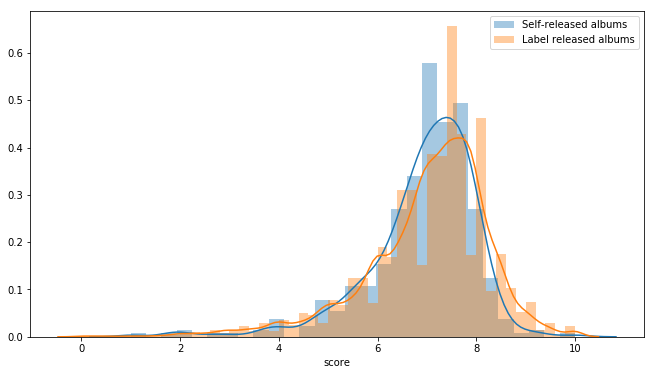

In [138]:
plt.figure(figsize=(11,6))
sns.distplot(self_df['score'], label='Self-released albums');
sns.distplot(label_df['score'], label='Label released albums');
plt.legend()

In [139]:
self_df['score'].mean() - label_df['score'].mean()

-0.09143086002903633

In [140]:
t_stat, p_val = ttest_ind(self_df['score'],label_df['score'])
print(f"T-Statistic: {t_stat}\nP-Value: {p_val}")

T-Statistic: -1.4400160399176198
P-Value: 0.14988154041527244


In [141]:
sample_size_calc(self_df['score'],label_df['score'])

82.96984976815433

## Hypothesis test (3?4?)
* Null: In sampling the 500 worst and 500 best reviewed albums, there is no statistically significant difference in the genres each represents with regards to score. 
* Alternative: The 500 worst reviewed and 500 best reviewed albums have a statistically significant difference in the genres they have. 

### 500 Best Rated Albums

In [142]:
query = """
SELECT 
    reviewid
,   score
,   author
,   author_type
FROM 
    reviews
ORDER BY 
    score DESC
LIMIT 500;
"""

cur = conn.cursor()
cur.execute(query)
names = [description[0] for description in cur.description]
best_100 = pd.DataFrame(cur.fetchall(),columns=names)
best_wgenres = genres_hot_df.merge(best_100, on='reviewid')
best_wgenres.head()

,reviewid,genre,electronic,experimental,folk/country,global,jazz,metal,pop/r&b,rap,rock,score,author,author_type
0,22703,electronic,1,0,0,0,0,0,0,0,0,9.3,nate patrin,contributor
1,22661,rock,0,0,0,0,0,0,0,0,1,9.0,jenn pelly,associate reviews editor
2,22707,jazz,0,0,0,0,1,0,0,0,0,9.0,seth colter-walls,contributor
3,22643,rock,0,0,0,0,0,0,0,0,1,9.3,jesse jarnow,contributor
4,22555,electronic,1,0,0,0,0,0,0,0,0,9.5,andy beta,contributor


### 500 Worst Rated Albums

In [143]:
query = """
SELECT 
    reviewid
,   score
,   author
,   author_type
FROM 
    reviews
ORDER BY 
    score ASC
LIMIT 500;
"""

cur = conn.cursor()
cur.execute(query)
names = [description[0] for description in cur.description]
worst_100 = pd.DataFrame(cur.fetchall(),columns=names)
worst_wgenres = genres_hot_df.merge(worst_100, on='reviewid')
worst_wgenres.head()

,reviewid,genre,electronic,experimental,folk/country,global,jazz,metal,pop/r&b,rap,rock,score,author,author_type
0,22720,rap,0,0,0,0,0,0,0,1,0,3.5,marcus j. moore,contributor
1,22589,electronic,1,0,0,0,0,0,0,0,0,3.5,kevin lozano,tracks coordinator
2,22319,rock,0,0,0,0,0,0,0,0,1,2.0,ian cohen,contributor
3,22319,rap,0,0,0,0,0,0,0,1,0,2.0,ian cohen,contributor
4,22143,electronic,1,0,0,0,0,0,0,0,0,2.5,stacey anderson,associate features editor


In [144]:
# Creating binary genre columns
genres = ['rock', 'electronic', 'pop/r&b', 'rap', 'metal', 'experimental', 'jazz', 'folk/country', 'global']

for genre in genres:
    best_wgenres[genre] = best_wgenres['genre'].apply(lambda x: 1 if x == genre else 0)
    worst_wgenres[genre] = worst_wgenres['genre'].apply(lambda x: 1 if x == genre else 0)
    

In [145]:
# Correcting column names for use in ANOVA test
best_wgenres.rename(columns={'pop/r&b': 'pop_rb', 'folk/country': 'folk_country'}, inplace=True)
worst_wgenres.rename(columns={'pop/r&b': 'pop_rb', 'folk/country': 'folk_country'}, inplace=True)

### Creating ANOVA table with Best rated songs to look for styles that perform the best

In [146]:
formula = """score ~ C(rock) + C(electronic) + C(rap) + C(metal) 
            + C(experimental) +C(jazz) + C(pop_rb) + C(folk_country)"""
lm = ols(formula, best_wgenres).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq     df          F    PR(>F)
C(rock)           0.407402    1.0   3.708124  0.054633
C(electronic)     0.018879    1.0   0.171834  0.678639
C(rap)            0.544781    1.0   4.958531  0.026342
C(metal)          0.062107    1.0   0.565292  0.452438
C(experimental)   0.019272    1.0   0.175411  0.675500
C(jazz)           0.157476    1.0   1.433328  0.231707
C(pop_rb)         1.148879    1.0  10.456954  0.001291
C(folk_country)   0.019713    1.0   0.179424  0.672025
Residual         64.272491  585.0        NaN       NaN


### Creating ANOVA tables for Worst rated songs:

In [147]:
formula = """score ~ C(rock) + C(electronic) + C(rap) + C(metal) 
            + C(experimental) +C(jazz) + C(pop_rb) + C(folk_country)"""
lm = ols(formula, worst_wgenres).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                     sum_sq     df         F    PR(>F)
C(rock)            0.172404    1.0  0.225969  0.634690
C(electronic)      1.091531    1.0  1.430664  0.232096
C(rap)             0.101879    1.0  0.133532  0.714918
C(metal)           0.023072    1.0  0.030241  0.862000
C(experimental)    0.146514    1.0  0.192035  0.661375
C(jazz)            0.686205    1.0  0.899406  0.343297
C(pop_rb)          0.126617    1.0  0.165956  0.683867
C(folk_country)    0.556711    1.0  0.729678  0.393305
Residual         491.342202  644.0       NaN       NaN


### Creating ANOVA table for Best reviews by author type:

In [148]:
# Create reviewer types
reviewer = list(best_wgenres['author_type'].value_counts().index)

rev_names = {}
for r in reviewer:
    rev_names[r] = r.replace(" ","_")
rev_names

{'contributor': 'contributor',
 'executive editor': 'executive_editor',
 'senior editor': 'senior_editor',
 'editor-in-chief': 'editor-in-chief',
 'contributing editor': 'contributing_editor',
 'associate reviews editor': 'associate_reviews_editor',
 'senior staff writer': 'senior_staff_writer',
 'deputy news editor': 'deputy_news_editor'}

In [149]:
for old, new in rev_names.items():
    best_wgenres[new] = best_wgenres['author_type'].apply(lambda x: 1 if x == old else 0)
    worst_wgenres[new] = worst_wgenres['author_type'].apply(lambda x: 1 if x == old else 0)

In [150]:
best_wgenres.rename(columns={'editor-in-chief':'ec'}, inplace=True)
worst_wgenres.rename(columns={'editor-in-chief':'ec'}, inplace=True)
worst_wgenres.head()

,reviewid,genre,electronic,experimental,folk_country,global,jazz,metal,pop_rb,rap,...,author,author_type,contributor,executive_editor,senior_editor,ec,contributing_editor,associate_reviews_editor,senior_staff_writer,deputy_news_editor
0,22720,rap,0,0,0,0,0,0,0,1,...,marcus j. moore,contributor,1,0,0,0,0,0,0,0
1,22589,electronic,1,0,0,0,0,0,0,0,...,kevin lozano,tracks coordinator,0,0,0,0,0,0,0,0
2,22319,rock,0,0,0,0,0,0,0,0,...,ian cohen,contributor,1,0,0,0,0,0,0,0
3,22319,rap,0,0,0,0,0,0,0,1,...,ian cohen,contributor,1,0,0,0,0,0,0,0
4,22143,electronic,1,0,0,0,0,0,0,0,...,stacey anderson,associate features editor,0,0,0,0,0,0,0,0


### ANOVA Table for author type by review score: Best scores

In [151]:
formula = """score ~ C(contributor) + C(executive_editor) + C(senior_editor) 
            + C(ec) + C(contributing_editor) + C(associate_reviews_editor) 
            + C(senior_staff_writer) + C(deputy_news_editor)"""
lm = ols(formula, best_wgenres).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                                sum_sq     df         F    PR(>F)
C(contributor)                0.099847    1.0  0.895279  0.344441
C(executive_editor)           0.632875    1.0  5.674655  0.017530
C(senior_editor)              0.080004    1.0  0.717355  0.397359
C(ec)                         0.200698    1.0  1.799553  0.180287
C(contributing_editor)        0.066484    1.0  0.596123  0.440373
C(associate_reviews_editor)   0.277094    1.0  2.484554  0.115510
C(senior_staff_writer)        0.099482    1.0  0.892007  0.345324
C(deputy_news_editor)         0.047042    1.0  0.421799  0.516296
Residual                     65.243010  585.0       NaN       NaN


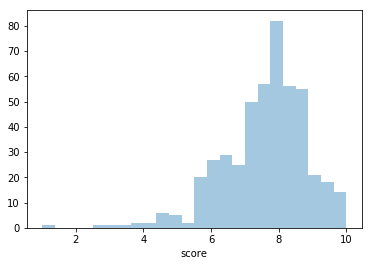

In [152]:
# Looking at scoring for the one Executive Editor - Mark Richardson
mark_richardson = reviews_df[reviews_df['author_type'] == 'executive editor'].copy()
sns.distplot(mark_richardson['score'], kde=False)

### ANOVA Table for author type by review score: Worst scores

In [153]:
formula = """score ~ C(contributor) + C(executive_editor) + C(senior_editor) 
            + C(ec) + C(senior_staff_writer)"""
worst = ols(formula, worst_wgenres).fit()
table = sm.stats.anova_lm(worst, typ=2)
print(table)

                            sum_sq     df         F    PR(>F)
C(contributor)            0.207015    1.0  0.273110  0.601432
C(executive_editor)       0.398292    1.0  0.525460  0.468784
C(senior_editor)          0.463840    1.0  0.611935  0.434346
C(ec)                     2.182150    1.0  2.878869  0.090230
C(senior_staff_writer)    0.470435    1.0  0.620636  0.431099
Residual                490.418612  647.0       NaN       NaN
